In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import resnet
from tensorboardX import SummaryWriter



import params as hps

In [2]:
device = torch.device('cuda:' + str(hps.gpu))
writer = SummaryWriter()

if hps.dataset=='MNIST':
    base_model = models.LeNetMadry().to(device)
    train_loader = dl.MNIST_train_loader
    noise_loader = dl.Noise_train_loader_MNIST
elif hps.dataset=='CIFAR10':
    base_model = resnet.ResNet50().to(device).to(device)
    train_loader = dl.CIFAR10_train_loader
    noise_loader = dl.Noise_train_loader_CIFAR10
    
noise_loader = dl.PrecomputeLoader(noise_loader)

In [3]:

if hps.use_gmm:
    loading_string = hps.dataset+'_n'+str(hps.n) 
    gmm = torch.load('SavedModels/gmm_'+loading_string+'.pth')
    gmm.alpha = nn.Parameter(gmm.alpha)
    model = models.RobustModel(base_model, gmm, -5.).to(device)
    model.loglam.requires_grad = False
else:
    model = base_model

saving_string = hps.dataset+'_lam'+str(hps.lam)+'_n'+str(hps.n)



lr = .1*hps.lr

if hps.use_gmm:
    param_groups = [{'params':model.base_model.parameters(),'lr':lr, 'weight_decay':hps.decay},
                   {'params':model.mm.parameters(),'lr':lr, 'weight_decay':0.}]
else:
    param_groups = [{'params':model.parameters(),'lr':lr, 'weight_decay':hps.decay}]
    
optimizer = optim.Adam(param_groups)

In [5]:
import pandas as pd

In [55]:
data = enumerate(dl.MNIST_test_loader).__next__()[1][0].to(device)

In [101]:
model = torch.load('SavedModels/gmm_model_MNIST_lam-2.0_n1000.pth').to(device)
model.mm.logvar.exp().mean()
print(model.mm.mu[:,0:50].mean())

tensor(-0.0033, device='cuda:2', grad_fn=<MeanBackward1>)


In [102]:
stringA = 'SavedModels/gmm_model_MNIST_lam-'
stringB = '.0_n1000.pth'
gmm_models =[]
for i in range(2, 8):
     gmm_models.append( torch.load(stringA+str(i)+stringB).to(device) )


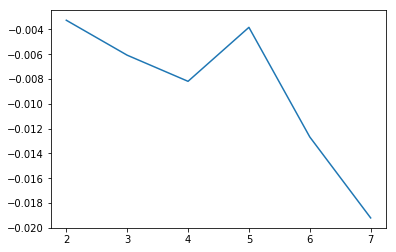

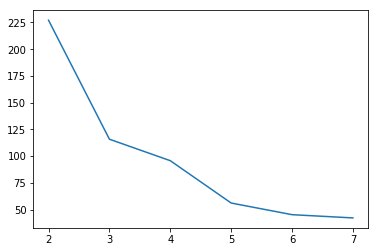

In [108]:
mean_mu = []
mean_var = []
for i in range(6):
    mean_mu.append(gmm_models[i].mm.mu[:,0:50].mean())
    mean_var.append(gmm_models[i].mm.logvar.exp().mean())
plt.plot(range(2, 8), mean_mu)
plt.show()

plt.plot(range(2, 8), mean_var)
plt.show()

In [37]:
base_model = torch.load('SavedModels/base_model_MNIST.pth').to(device)

tensor(-0.2441, device='cuda:2', grad_fn=<MinBackward1>)

(array([ 64.,   4.,   2.,   9.,   5.,   5.,  29., 194., 536., 152.]),
 array([ 12.3387289 ,  40.02455511,  67.71038132,  95.39620752,
        123.08203373, 150.76785994, 178.45368614, 206.13951235,
        233.82533855, 261.51116476, 289.19699097]),
 <a list of 10 Patch objects>)

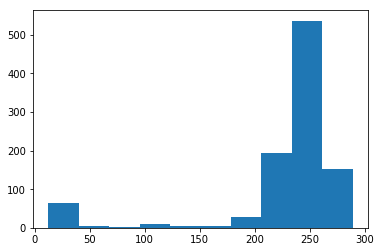

In [110]:
plt.hist(gmm_models[0].mm.logvar.exp().detach().cpu())

(array([ 64.,   4.,   2.,   9.,   5.,   5.,  29., 194., 536., 152.]),
 array([ 12.3387289 ,  40.02455511,  67.71038132,  95.39620752,
        123.08203373, 150.76785994, 178.45368614, 206.13951235,
        233.82533855, 261.51116476, 289.19699097]),
 <a list of 10 Patch objects>)

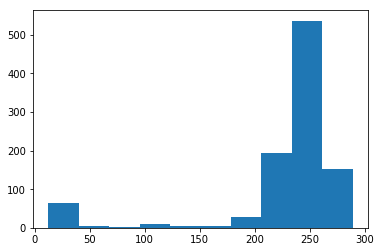

In [120]:
plt.hist(gmm_models[0].mm.logvar.exp().detach().cpu())

(array([125.85174714,  94.61625328,  43.06252553,  20.6214911 ,
         10.61400277,   3.33582944,   3.63908666,   1.21302889,
          0.        ,   0.30325722]),
 array([1.17069852e-07, 3.29764777e-03, 6.59517847e-03, 9.89270917e-03,
        1.31902399e-02, 1.64877706e-02, 1.97853013e-02, 2.30828320e-02,
        2.63803627e-02, 2.96778934e-02, 3.29754241e-02]),
 <a list of 10 Patch objects>)

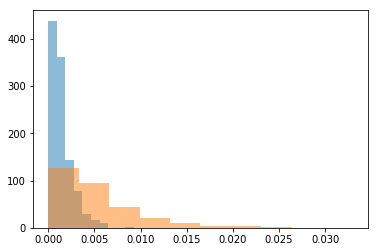

In [129]:
plt.hist(gmm_models[5].mm.alpha.exp().detach().cpu(),alpha=.5, density = True)
plt.hist(gmm_models[0].mm.alpha.exp().detach().cpu(),alpha=.5, density = True)

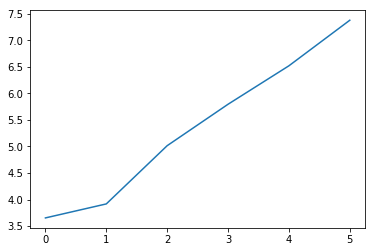

In [138]:
plt.plot([(mo.mm.alpha.exp().detach().cpu().sum()/mo.loglam.exp()).log() for mo in gmm_models])